# Data Mining CHEmBL dataset for Drug Discovery applications 

Database : CHEmBL [[1]](https://www.ebi.ac.uk/chembl/) <br>
Disease : Alzheimer
Target Protein : Amyloid beta A4 protein <br>
based on cambridge reasearch study in 04 Nov 2020 [[2](https://www.cam.ac.uk/research/news/researchers-show-how-to-target-a-shape-shifting-protein-in-alzheimers-disease)]


## Background information on Drug Discovery

**Quantitative Structure-activity relationship(QSAR)** modelng is a mathematical modeling that seeks to discern the relationship between the chemical structure and their bioactivity <br>
- The chemical structure is defined by a set of molecular descriptors that can account for local or global physicochemical properties
- Local features e.g. the number/presence of specific functional moieties (molecular fingerprint)
- Global features e.g. molecular weight and lipopholocity
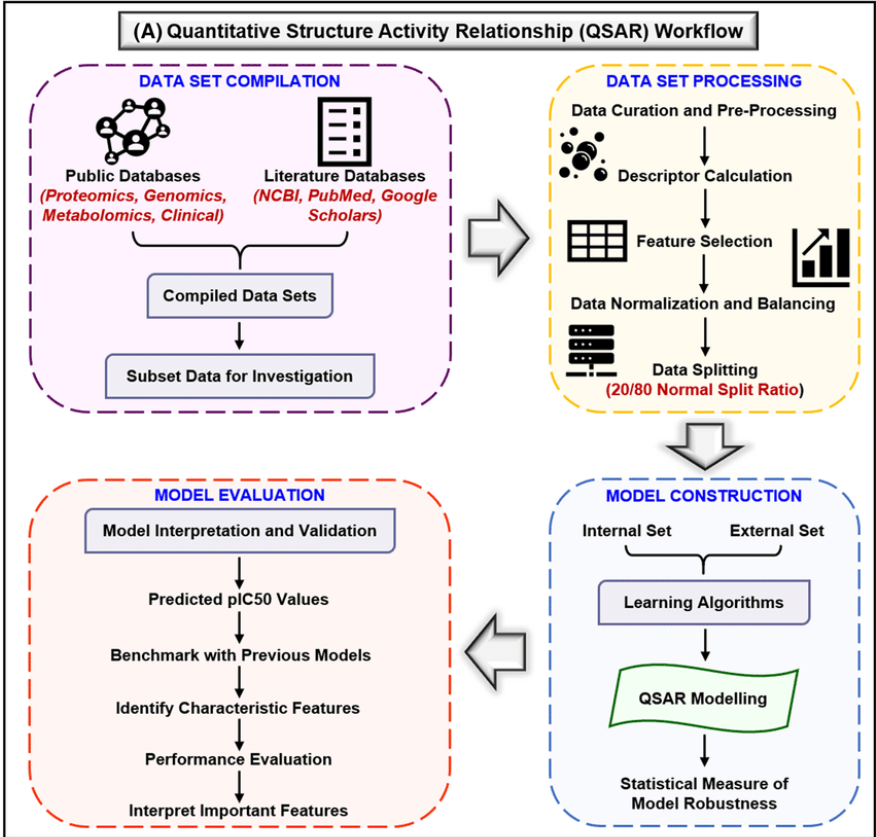

**Half-maximal inhibitory concentration (IC50)** is the most widely used and informative measure of a drug's efficacy. It indicates how much drug is needed to inhibit a biological process by half, thus providing a measure of potency of an antagonist drug in pharmacological research. 

**potency of the drug** represents the , the lower this value the better the drug is

## Download then import libraries and dataset

### Install all needed libraries

**What does the RDKit deos ????**
- calculate the lipinski discriptive for exploratory data analysis

In [67]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
# import RDKit modules needed : Chem , discriptor and lipinski
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [69]:
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [292]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import time
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load dataset for Alzheimer using the chembl API

In [70]:
!pip install chembl_webresource_client
from chembl_webresource_client.new_client import new_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Using the API, search for the "Alzheimer" illness

In [71]:
# search for the target proteins
target = new_client.target
target_query = target.search('Alzheimer')
#acetylcholinesterase
#Alzheimer
# type of target_query is in the form of python dictionary
targets=pd.DataFrame.from_dict(target_query)
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cross_references    6 non-null      object 
 1   organism            6 non-null      object 
 2   pref_name           6 non-null      object 
 3   score               6 non-null      float64
 4   species_group_flag  6 non-null      bool   
 5   target_chembl_id    6 non-null      object 
 6   target_components   6 non-null      object 
 7   target_type         6 non-null      object 
 8   tax_id              6 non-null      int64  
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 518.0+ bytes


In [72]:
targets.head(6)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Nucleosome-remodeling factor subunit BPTF,13.0,False,CHEMBL3085621,"[{'accession': 'Q12830', 'component_descriptio...",SINGLE PROTEIN,9606
1,"[{'xref_id': 'Q92542', 'xref_name': None, 'xre...",Homo sapiens,Nicastrin,11.0,False,CHEMBL3418,"[{'accession': 'Q92542', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,Gamma-secretase,11.0,False,CHEMBL2094135,"[{'accession': 'Q96BI3', 'component_descriptio...",PROTEIN COMPLEX,9606
3,[],Rattus norvegicus,Amyloid beta A4 protein,9.0,False,CHEMBL3638365,"[{'accession': 'P08592', 'component_descriptio...",SINGLE PROTEIN,10116
4,[],Mus musculus,Amyloid-beta A4 protein,8.0,False,CHEMBL4523942,"[{'accession': 'P12023', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P05067', 'xref_name': None, 'xre...",Homo sapiens,Beta amyloid A4 protein,7.0,False,CHEMBL2487,"[{'accession': 'P05067', 'component_descriptio...",SINGLE PROTEIN,9606


#### I chose the target protien to be **Amyloid-beta A4 protein** according to [studys linking the protein to the disease](https://www.nia.nih.gov/health/what-happens-brain-alzheimers-disease#:~:text=It%20is%20formed%20from%20the,neurons%20and%20disrupt%20cell%20function.)

In [129]:
# select the Protein with the name "Alzheimer" which are the targets in index 3 or 4
target_selected = targets.target_chembl_id[3]
target_selected

'CHEMBL3638365'

#### Filter the dataset to contain only the molecules with the target protein of "Amyloid-beta A4 protein"

In [130]:
activity = new_client.activity
res = activity.filter(target_chembl_id= target_selected)
df_types = pd.DataFrame.from_dict(res).type.unique()
df_types #only one type exists

array(['IC50'], dtype=object)

In [131]:
# retrieve bioactivity of only the protein we choose with the id and choose the activity to be standard type of the protein
# to unify the protein type and activity type 
activity = new_client.activity
res = activity.filter(target_chembl_id= target_selected).filter(standard_type="IC50")
#create a dataframe that has the protein and its activity
df = pd.DataFrame.from_dict(res)
df.head()
df.shape

(43, 45)

In [136]:
df.standard_value.astype(float).head()

0    13.0
1     6.0
2    15.0
3    28.0
4    12.0
Name: standard_value, dtype: float64

In [137]:
# make sure that all rows have standard_type as IC50 and not any derivatives of it 
df.shape
df.standard_value= df.standard_value.astype(float)
df.standard_value.describe()
# Note the lower the standard value the better cuz high values means we need to increase the dosage of the medicine 
# =====> always choose the row with the smallest dosage 

count      43.000000
mean      479.441860
std      1223.296547
min         4.000000
25%        10.500000
50%        14.000000
75%        31.500000
max      4400.000000
Name: standard_value, dtype: float64

In [138]:
#Save my extracted data into a .csv file with index = false aka dont put the first column as indexing for the records
df.to_csv('QSAR_Alzheimer.csv', index=False)
#mount the file to google drive so its avaible all the time
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [119]:
# load the content from colab to google drive folders
#------------------------------------------------------
#copy the data from colab to gdrive
! cp "QSAR_Alzheimer.csv" '/content/'

cp: 'QSAR_Alzheimer.csv' and '/content/QSAR_Alzheimer.csv' are the same file


In [120]:
! ls
df

gdrive			    QSAR_Alzheimer.csv		      sample_data
plot_bioactivity_class.pdf  QSAR_Alzheimer_ready_for_EDA.csv


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,16881210,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,13.0
1,None,16881211,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,6.0
2,None,16881212,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,15.0
3,None,16881213,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,28.0
4,None,16881214,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,12.0
5,None,16881215,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,5.0
6,None,16881216,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,10.0
7,None,16881217,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,13.0
8,None,16881218,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,7.0
9,None,16881219,[],CHEMBL3880967,Inhibition of Abeta42 production in Wistar rat...,B,None,None,BAO_0000190,BAO_0000019,...,Rattus norvegicus,Amyloid beta A4 protein,10116,None,None,IC50,nM,UO_0000065,None,13.0


## Preprocessing and feature engineering of the collected data

In [237]:
df = pd.read_csv("QSAR_Alzheimer.csv")
df.columns

Index(['activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

### Handling missing data && cleaning

In [238]:
#Handling the missing data
df=df.dropna(subset=['standard_value', 'canonical_smiles'])
df = df.drop_duplicates(['canonical_smiles']).reset_index(drop=True)

In [239]:
df.canonical_smiles[9]

'CC(C(=O)O)c1ccc(-c2ccc(C(F)(F)F)cc2)c(F)c1'

In [240]:
#making sure all standard values are positive values
for mol in df.standard_value :
  if (mol)*(10**-9) < 0 :
    print((mol)*(10**-9))

-1e-09


### Simplifying the molecular smile notation

In [241]:
# NOTE I am cleaning , by removing insignificant element and keeping the largest compound in each SMILES expression
selected_features=["molecule_chembl_id", "canonical_smiles", "standard_value"]
df = df[selected_features]

smileless= df.drop(columns=['canonical_smiles'])

smiles=[]
for i in df['canonical_smiles'].tolist():
  strg= str(i).split(".")
  strg = max(strg,key= len)
  smiles.append(strg)

smiles=pd.DataFrame(data=smiles, columns=["canonical_smiles"])
df = pd.concat([smileless, smiles], axis=1)

### <u>Discretization</u> 
Classify bioactivity to active, inactive and intermediate according to the standard value<br>
The bioactivity data is in the IC50 unit. Compounds having values of **less than 1000 nM** will be considered to be **active** while those **greater than 10,000** nM will be considered to be **inactive**. As for those values in **between 1,000 and 10,000 nM** will be referred to as **intermediate**.



In [242]:
# if <= 1000 then active
# if >=10000 then inactive
# otherwise it is intermediate 
bioactivity_class=[] 
for i in df['standard_value']:
  if float(i) <= 1000:
    bioactivity_class.append("active")
  elif float(i) >= 10000:
    bioactivity_class.append("inactive")
  else:
    bioactivity_class.append("intermediate")
act_series=pd.Series(bioactivity_class, name="class")
df = pd.concat([df, act_series], axis=1)
df.head()

,molecule_chembl_id,standard_value,canonical_smiles,class
0,CHEMBL311039,5000.0,CC12CCC(C1)C(C)(C)C2NS(=O)(=O)c1ccc(F)cc1,intermediate
1,CHEMBL450926,2700.0,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1cccs1,intermediate
2,CHEMBL310242,1800.0,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,intermediate
3,CHEMBL74874,11000.0,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive
4,CHEMBL75183,10000.0,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive


In [243]:
df["class"].value_counts()

active          368
inactive        348
intermediate    223
Name: class, dtype: int64

**Remove the intermediate activity class row and save it**
- we will select only 2 classes (labels) which are **active** & **inactive**<br>
To simplyfy the problem convert from Multi-Class => Binary-Class 


In [244]:
print("before: ",df.shape)
df.drop(df[df["class"] == 'intermediate'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
print("after: ",df.shape)


before:  (939, 4)
after:  (716, 4)


### Compute Lipinski Discriptors
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

**The Lipinski's Rule stated the following:**
- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

In [245]:
def lipinski(smiles, verbose=False):
  moldata=[]
  for element in smiles:
    # get all molecules from the smiles
    mol=Chem.MolFromSmiles(element)
    moldata.append(mol)

  basedata = np.arange(1,1)
  i = 0
  for mol in moldata:
    # calculate the molecule weight
    molWt = Descriptors.MolWt(mol)
    # calculate the molecule log-p
    molLogP = Descriptors.MolLogP(mol)
    # calculate the molecule h bond donor
    molHBD = Lipinski.NumHDonors(mol)
    # calculate the molecule h bond acceptor
    molHBA = Lipinski.NumHAcceptors(mol)
    # put all as a row
    row = np.array([molWt, molLogP, molHBD, molHBA])


    #vstack: is a data structure stack (FIFO)
    if i == 0: #first element in the stack
      basedata=row
    else: #stack all rows vectically
      basedata = np.vstack([basedata,row])
    i = i+1
    
  columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
  descriptors = pd.DataFrame(data=basedata,columns=columnNames)
  return descriptors

In [246]:
df_lipinski = lipinski(smiles=df['canonical_smiles'])
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,327.877,3.83310,1.0,2.0
1,372.328,3.94220,1.0,2.0
2,244.265,3.68080,1.0,1.0
3,313.155,4.98760,1.0,1.0
4,313.155,4.98760,1.0,1.0
...,...,...,...,...
711,372.505,6.06612,3.0,3.0
712,328.496,6.36792,2.0,2.0
713,514.483,4.66972,0.0,7.0
714,496.493,4.53062,0.0,7.0


In [247]:
# merge the dataframes into the main dataframe aka df
df = pd.concat([df,df_lipinski], axis=1)
df

,molecule_chembl_id,standard_value,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL74874,11000.0,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive,327.877,3.83310,1.0,2.0
1,CHEMBL75183,10000.0,CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(...,inactive,372.328,3.94220,1.0,2.0
2,CHEMBL563,305000.0,CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1,inactive,244.265,3.68080,1.0,1.0
3,CHEMBL196279,75000.0,CC(C(=O)O)c1ccc(-c2ccc(Cl)c(Cl)c2)c(F)c1,inactive,313.155,4.98760,1.0,1.0
4,CHEMBL195970,77000.0,CC(C(=O)O)c1ccc(-c2cc(Cl)cc(Cl)c2)c(F)c1,inactive,313.155,4.98760,1.0,1.0
...,...,...,...,...,...,...,...,...
711,CHEMBL513978,20300.0,CC(C)=CCC/C(C)=C/CC/C(C)=C/Cc1c(O)cc(C)c(C(=O)...,inactive,372.505,6.06612,3.0,3.0
712,CHEMBL4641877,19900.0,CC(C)=CCC/C(C)=C/CC/C(C)=C/Cc1c(C)cc(O)cc1O,inactive,328.496,6.36792,2.0,2.0
713,CHEMBL3609637,31.0,COc1cc(-c2cn(C3CCc4c(F)cccc4N(CC(F)(F)F)C3=O)n...,active,514.483,4.66972,0.0,7.0
714,CHEMBL4534005,10.0,COc1cc(-c2cn(C3CCc4ccccc4N(CC(F)(F)F)C3=O)nn2)...,active,496.493,4.53062,0.0,7.0


### Convert the standard from IC50 to pIC50
<hr>
<strong>WHY?</strong> : normalize the data since the IC50 is a skewed value while pIC50 is IC50 normalized by taking the logarithmic value <br>
step 1 : create pIC50 column ( func= -log(IC50) )<br>
step 2 : replace standard_Value column with it <br>

In [248]:
#Note the standard value of IC50 is in nano Moles (nM) => convert to M before claculating the pIC50
def pIC50(data):
  pIC50=[]
  for ic50 in data['standard_value']:
    if float(ic50) < 0:
      ic50= -1 *ic50
    ic50 = float(ic50) * (10**-9) #convert from mM to M 
    pIC50.append(-np.log10(ic50))

  df=data.drop(columns=['standard_value'],axis=1)

  pIC50_series= pd.Series(data=pIC50, name="pIC50")
  df_edited =pd.concat([data,pIC50_series],axis=1)
  return df_edited

In [249]:
print(df.standard_value.describe())

count       716.000000
mean      25871.883659
std       65570.140295
min          -1.000000
25%          59.500000
50%         925.000000
75%       22872.500000
max      800000.000000
Name: standard_value, dtype: float64


In [250]:
df=pIC50(df)
df.pIC50.describe()

count    716.000000
mean       5.927925
std        1.512535
min        3.096910
25%        4.640723
50%        6.033865
75%        7.225530
max        9.522879
Name: pIC50, dtype: float64

In [270]:
df.columns

Index(['molecule_chembl_id', 'standard_value', 'canonical_smiles', 'class',
       'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50'],
      dtype='object')

### Exploratory Data Analysis (EDA)

***Frequency plot of the 2 bioactivity classes***

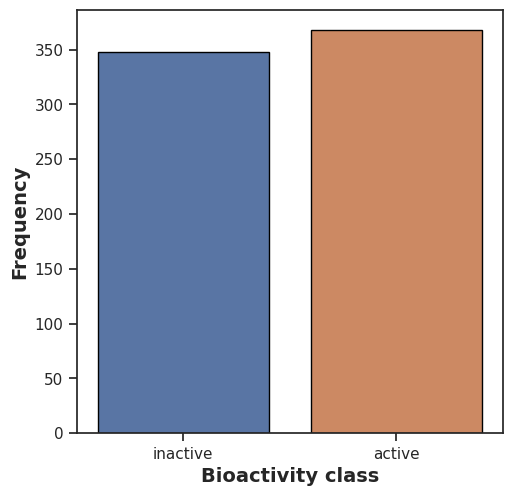

In [251]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

***Scatter plot of MW versus LogP***

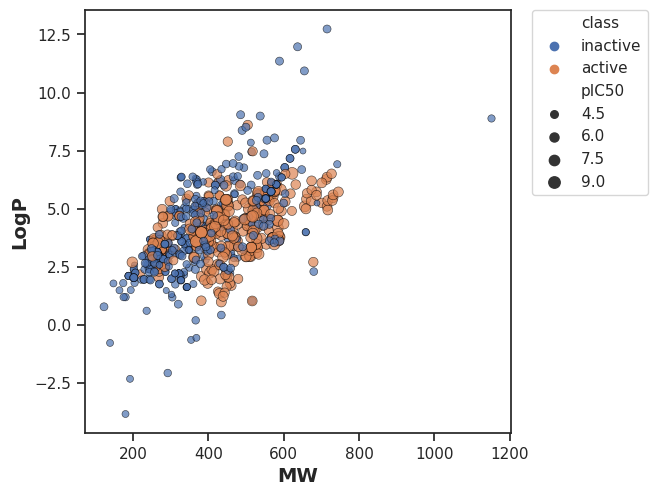

In [252]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

**Box plots** <br>
pIC50 value

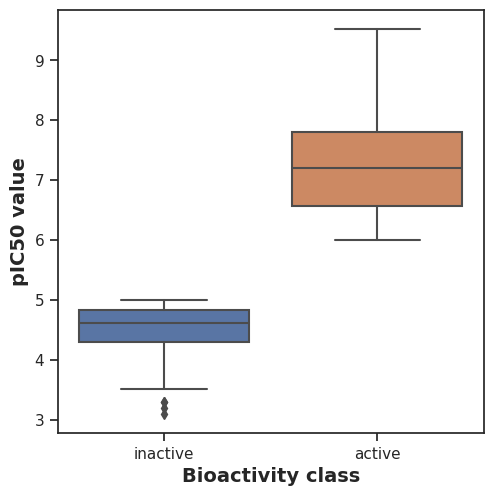

In [253]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')


**MW**

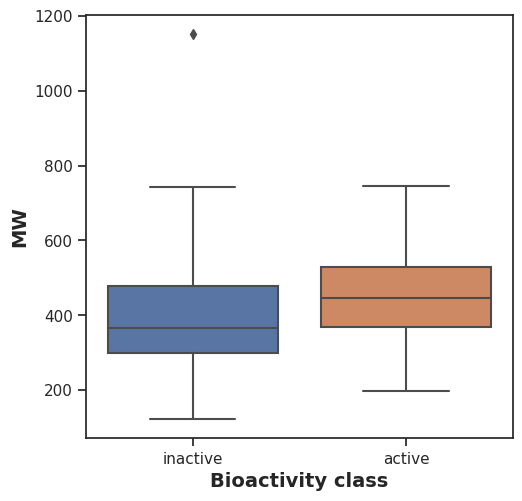

In [254]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

**LogP**

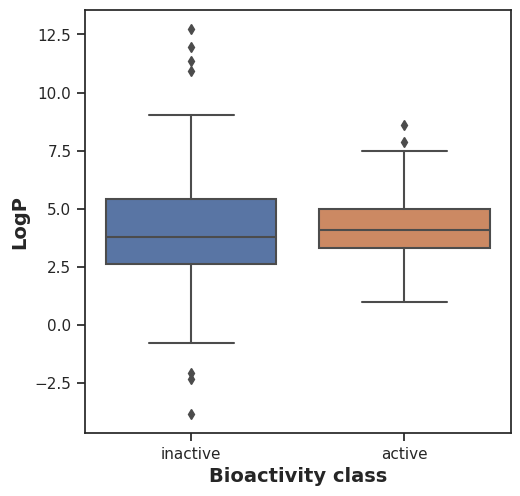

In [255]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**NumHDonors**

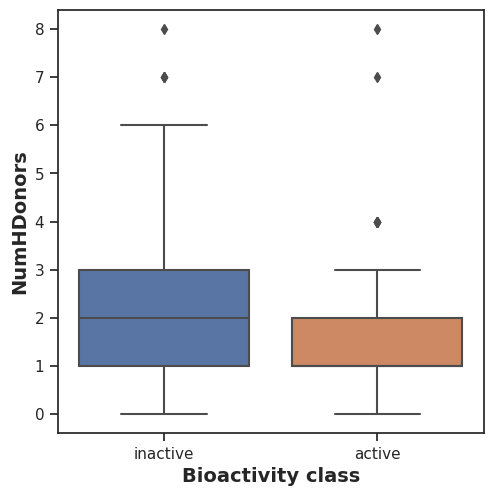

In [256]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**NumHAcceptors**

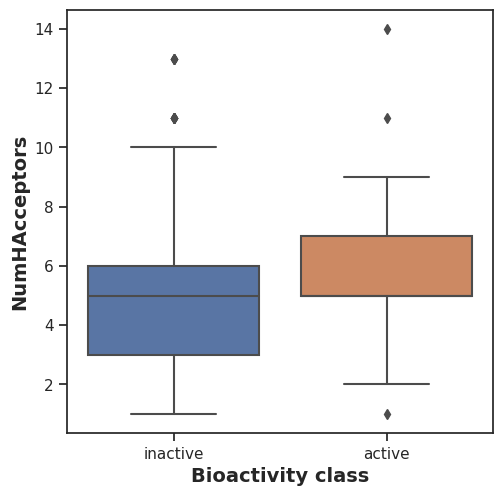

In [257]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

### Compute the Padel discriptor


- download **padel.zip** and **padel.sh** from github downloadable links
- upzip the zip file
- create a dataframe with canonical_smiles and molecule_id
- save the file to csv without header or index as <u>**[ .smi ]**</u>  file
- run the .sh file using bash command

#### install PaDEL library

In [259]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

--2023-05-07 16:30:33--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2023-05-07 16:30:33--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.1’

padel.zip.1         100%[===================>]  24.57M  --.-KB/s    in 0.07s   

2023-05-07 16:30:34 (360 MB/s) - ‘padel.zip.1’ saved [25768637/25768637]



In [260]:
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2023-05-07 16:30:35--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2023-05-07 16:30:36--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: ‘padel.sh.1’

padel.sh.1          100%[===================>]     231  --.-KB/s    in 0s      

2023-05-07 16:30:36 (13.5 MB/s) - ‘padel.sh.1’ saved [231/231]



In [265]:
! unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._PaDEL-Descriptor  
replace PaDEL-Descriptor/MACCSFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
replace __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
replace PaDEL-Descriptor/AtomPairs2DFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
replace __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
replace PaDEL-Descriptor/EStateFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace PaDEL-Descriptor/EStateFingerprinter.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [266]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [267]:
! cat molecule.smi | head -5
! cat molecule.smi | wc -l

CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(Cl)cc1	CHEMBL74874
CC12CC[C@@H](C1)C(C)(C)[C@@H]2NS(=O)(=O)c1ccc(Br)cc1	CHEMBL75183
CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1	CHEMBL563
CC(C(=O)O)c1ccc(-c2ccc(Cl)c(Cl)c2)c(F)c1	CHEMBL196279
CC(C(=O)O)c1ccc(-c2cc(Cl)cc(Cl)c2)c(F)c1	CHEMBL195970
716


Calculate fingerprint descriptors<br>
Calculate PaDEL descriptors <br>


In [268]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


#### Compute PaDEL for the dataset

In [269]:
! bash padel.sh

Processing CHEMBL74874 in molecule.smi (1/716). 
Processing CHEMBL75183 in molecule.smi (2/716). 
Processing CHEMBL196279 in molecule.smi (4/716). Average speed: 1.28 s/mol.
Processing CHEMBL563 in molecule.smi (3/716). Average speed: 2.55 s/mol.
Processing CHEMBL195970 in molecule.smi (5/716). Average speed: 2.14 s/mol.
Processing CHEMBL264006 in molecule.smi (6/716). Average speed: 1.44 s/mol.
Processing CHEMBL193971 in molecule.smi (7/716). Average speed: 1.14 s/mol.
Processing CHEMBL194274 in molecule.smi (8/716). Average speed: 1.06 s/mol.
Processing CHEMBL196321 in molecule.smi (9/716). Average speed: 0.96 s/mol.
Processing CHEMBL196322 in molecule.smi (10/716). Average speed: 0.90 s/mol.
Processing CHEMBL380778 in molecule.smi (11/716). Average speed: 0.83 s/mol.
Processing CHEMBL197202 in molecule.smi (12/716). Average speed: 0.78 s/mol.
Processing CHEMBL194760 in molecule.smi (13/716). Average speed: 0.83 s/mol.
Processing CHEMBL196246 in molecule.smi (14/716). Average speed: 

#### Read the PaDEL descriptor without the molecule name column

In [285]:
#read the saved PaDEL descriptors in the file named "descriptors_output"
PaDEL = pd.read_csv('/content/descriptors_output.csv')
PaDEL = PaDEL.drop(columns=['Name'])


#### Dimension Reduction Technique : VarianceThreshold

In [288]:
selection = VarianceThreshold()  
print("Before", PaDEL.shape)  
PaDEL = selection.fit_transform(PaDEL)
print("After", PaDEL.shape)  

Before (716, 881)
After (716, 557)


### Prepare the output/input dataframes

- **Input** : PaDEL descriptors
- **Output** : pIC50 value

In [289]:
input = PaDEL.copy()
output = pd.DataFrame(df["pIC50"], columns=["pIC50"])

#### Split the data to training and testing
The ratio is: 
- 67 training
- 33 testing

In [290]:
X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.33, random_state=3)

## Apply Machine Learning Algorithms
 

#### Using Lazy regressor

In [293]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [01:44<00:00,  2.49s/it]


'tuple' object has no attribute '__name__'
Invalid Regressor(s)


100%|██████████| 42/42 [01:44<00:00,  2.48s/it]


[(0.0, 1.0)]

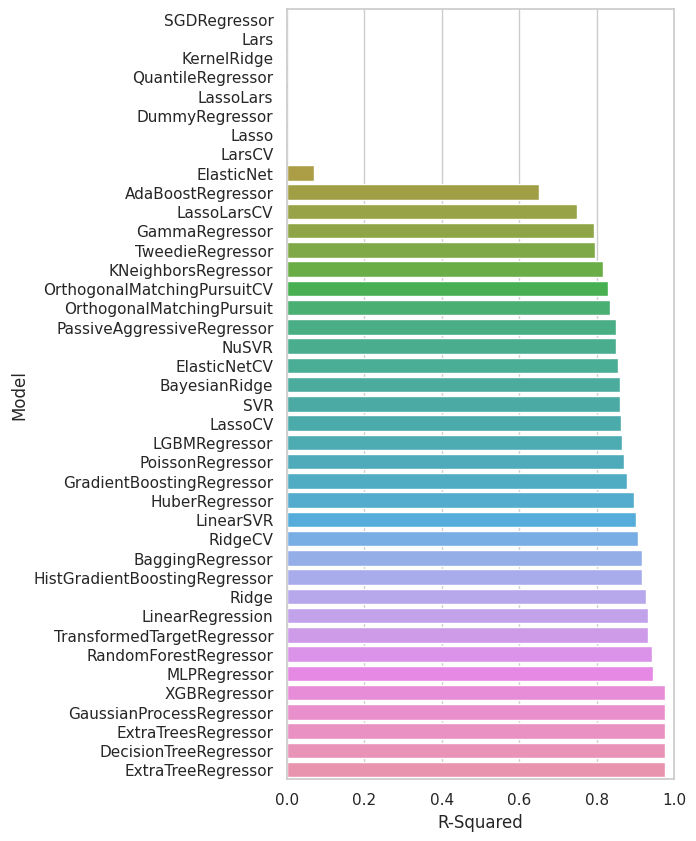

In [294]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

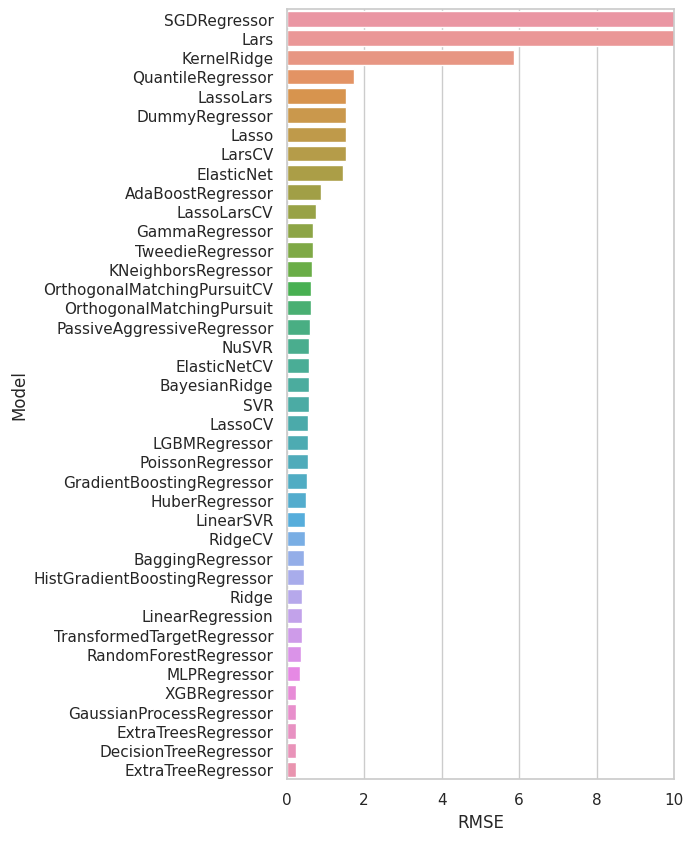

In [295]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

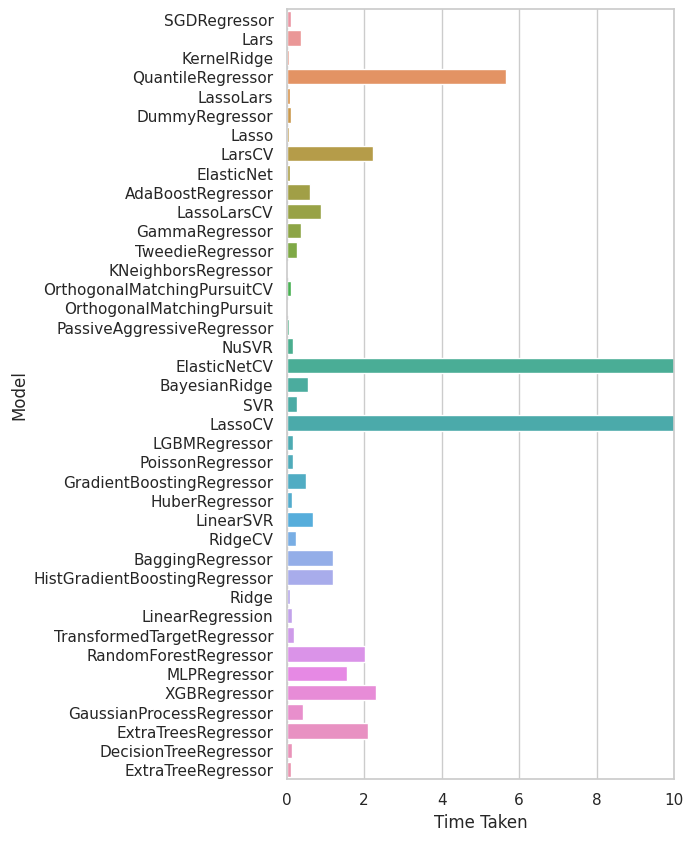

In [296]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))

#### **Models will be built :** <br>
1. Implement famous regression models <br>
  1.1. Random Forest <br>
  1.2. Gradient Boost (or any kind of boosting)<br>
  1.3. SVM<br>
  1.4. KKN<br>
2. Hyperparameter tuning for the best performing model in step 1

##### building the random forest model for prediction

In [297]:
model1 = RandomForestRegressor(random_state=0, n_estimators=80)
model1.fit(X_train, Y_train)
r2_model1 = model1.score(X_test, Y_test)
print(r2_model1)
start = time.time()
Y_pred = model1.predict(X_test)
end = time.time()
print(end - start)
mae1=mean_absolute_error(Y_pred, Y_test)
print(mae1)

0.7044907973721248
0.009124279022216797
0.5494507497483898


##### building the GradientBoost regressor model for prediction

In [298]:
model2= GradientBoostingRegressor(random_state=0,n_estimators=80)
model2.fit(X_train, Y_train)
r2_model2 = model2.score(X_test, Y_test)
print(r2_model2)
start = time.time()
Y_pred = model2.predict(X_test)
end = time.time()
print(end - start)
mae2=mean_absolute_error(Y_pred, Y_test)
print(mae2)

0.692595762382699
0.0014622211456298828
0.6104415933601136


##### building the KNN model for prediction

In [299]:
model3 = KNeighborsRegressor(n_neighbors=10)
model3.fit(X_train, Y_train)
r2_model3=model3.score(X_test, Y_test)
print(r2_model3)
start = time.time()
Y_pred = model2.predict(X_test)
end = time.time()
print(end - start)
mae3=mean_absolute_error(Y_pred, Y_test)
print(mae3)

0.6820897027952177
0.0016756057739257812
0.6104415933601136


##### building the Support Vector Machine model for prediction

In [300]:
model4 = SVR(kernel = 'rbf')
model4.fit(X_train, Y_train)
r2_model4=model4.score(X_test, Y_test)
print(r2_model4)
start = time.time()
Y_pred = model2.predict(X_test)
end = time.time()
print(end - start)
mae3=mean_absolute_error(Y_pred, Y_test)
print(mae3)

0.7082291097943629
0.0018320083618164062
0.6104415933601136


## Optimize the hyperparamters of the Final Model
(best performing model is Random forest)<br>
Using Grid Search and Cross Validation

In [301]:
forest = RandomForestRegressor(random_state=0, n_estimators=80)
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth)

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_test, Y_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [302]:
bestF.best_params_

{'max_depth': 8, 'n_estimators': 100}

In [303]:
forestOpt = RandomForestRegressor(random_state = 1, max_depth = 8,n_estimators = 800)                      
modelOpt = forestOpt.fit(X_test, Y_test)
y_pred = modelOpt.predict(X_test)
r2_forestOpt = forestOpt.score(X_test, Y_test)
print(r2_forestOpt)
start = time.time()
Y_pred = forestOpt.predict(X_test)
end = time.time()
print(end - start)
maeOpt=mean_absolute_error(y_pred, Y_test)
print(maeOpt)

0.9282056190086746
0.07024550437927246
0.2948134600763921


<function matplotlib.pyplot.show(close=None, block=None)>

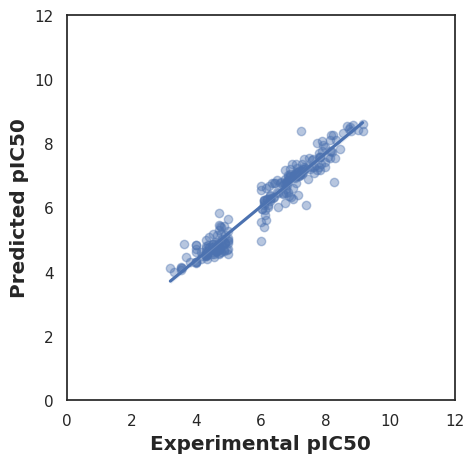

In [308]:
sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=Y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show